In [53]:
%%capture
! pip install interpret

In [2]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
from sklearn.metrics import ndcg_score, average_precision_score

In [6]:
data_path = './anime/'

# Read the dataset
animes = pd.read_csv(data_path+'anime.csv')
ratings = pd.read_csv(data_path+'rating.csv')

ratings = ratings.sample(1_000_000, random_state=42)

# Preprocessing & Feature Engineering

In [7]:
# 사용하는 피처만 남김
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]
# 칼럼명 변경
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']
# 결측값이 포함된 애니는 drop
animes = animes.dropna()


# 평점 테이블도 동일하게 처리, 무효한 값은 제거 (rating이 -1인 값)
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating'] != -1]

# 데이터 프레임 join
data = ratings.merge(animes, on='anime_id', how='inner')

# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저 피처 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby('user_id')['rating'].mean().rename('User-AvgRating')
user_num_ratings = data.groupby('user_id')['rating'].count().rename('User-NumRatings')

# 추출한 유저 피처 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)

# 애니 메타 데이터에서 아이템 관련 피처 수가 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')

# 애니 이름 피처에서 TF-IDF 피처 생성, 총 10개의 이름 생성 (most frequent 10 words)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 'type' 칼럼을 원핫 인코딩
onehot_encoder = OneHotEncoder(sparse_output=False)
item_type_onehot = onehot_encoder.fit_transform(animes[['type']])

# TF-IDF 피처와 type 원핫 피처를 결합
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
type_df = pd.DataFrame(item_type_onehot, columns=[f'Type-{cat}' for cat in onehot_encoder.categories_[0]], index=animes.anime_id)

animes_features = animes[['anime_id', 'members', 'anime_total_rating']]


item_features = pd.DataFrame(item_num_ratings)\
            .merge(tf_idf_df, on="anime_id")\
            .merge(type_df, on="anime_id")\
            .merge(animes_features.set_index('anime_id'), on="anime_id")


# 인터렉션 데이터와 함께, user 및 item 피처 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)

data = data.join(user_features, on='user_id')
data = data.merge(item_features, on='anime_id')

# implicit feedback 표현을 위해 이진화 (유저의 평균 평점보다 높은 경우 1)
# 절대값으로 지정하는 방법도 있음
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)

# Train-test split
X = data.drop(columns=['user_id','anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBM with 1000 samples...
[LightGBM] [Info] Number of positive: 515, number of negative: 485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515000 -> initscore=0.060018
[LightGBM] [Info] Start training from score 0.060018


 50%|█████     | 1/2 [00:00<00:00,  1.07it/s]

LGBM AUC: 0.6622325077028113
Training EBM with 1000 samples...


100%|██████████| 2/2 [00:11<00:00,  5.77s/it]


EBM AUC: 0.7088169677674265


  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBM with 10000 samples...
[LightGBM] [Info] Number of positive: 5099, number of negative: 4901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509900 -> initscore=0.039605
[LightGBM] [Info] Start training from score 0.039605


 50%|█████     | 1/2 [00:00<00:00,  1.33it/s]

LGBM AUC: 0.7388504851694132
Training EBM with 10000 samples...


100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


EBM AUC: 0.7480781292610339


  0%|          | 0/2 [00:00<?, ?it/s]

Training LGBM with 100000 samples...
[LightGBM] [Info] Number of positive: 50622, number of negative: 49378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506220 -> initscore=0.024881
[LightGBM] [Info] Start training from score 0.024881


 50%|█████     | 1/2 [00:01<00:01,  1.06s/it]

LGBM AUC: 0.7546555091491538
Training EBM with 100000 samples...


100%|██████████| 2/2 [00:47<00:00, 23.97s/it]

EBM AUC: 0.7558934106948343


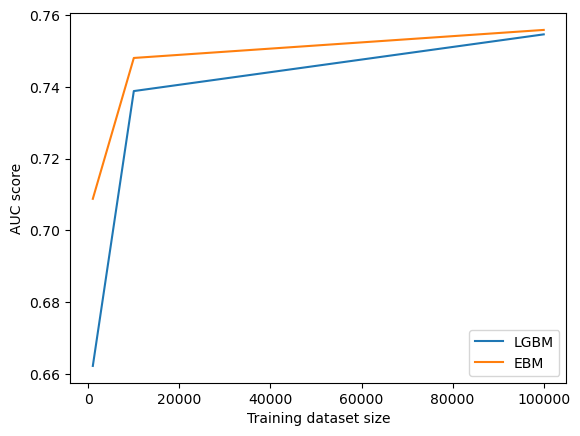

In [10]:
# 데이터셋 사이즈 지정
dataset_sizes = [1_000, 10_000, 100_000]

# 모델 정의
models = {
    'LGBM': LGBMClassifier(random_state=42),
    'EBM': ExplainableBoostingClassifier(random_state=42)

}

# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}


# 데이터 사이즈별로 iteration
for size in dataset_sizes:
    # 각 사이즈별로 데이터를 샘플링함
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    # 모델 별로 반복
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} samples...")
        
        # 모델 적합
        model.fit(X_train_sample, y_train_sample)

        # 예측 결과 생성
        y_pred = model.predict_proba(X_test)[:, 1]

        # AUC 점수 계산 
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)
        
        # ROC 곡선
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))

        print(f"{model_name} AUC: {auc_score}")


# AUC 스코어 시각화
for model_name, model_auc_scores in auc_scores.items():
    plt.plot(dataset_sizes, model_auc_scores, label=model_name)
plt.xlabel('Training dataset size')
plt.ylabel('AUC score')
plt.legend()
plt.show()

In [11]:
%%time
# 100만개 기준 54분
# 10만개 기준 8분

# EBM 모델 인스턴스 생성
ebm = ExplainableBoostingClassifier(random_state=42)

# 모델 적합 
ebm.fit(X_train, y_train)

CPU times: user 4.53 s, sys: 740 ms, total: 5.27 s
Wall time: 14min 16s


ExplainableBoostingClassifier()

In [12]:
# 모델 성능 평가 -> ROC 기준 
roc = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='ROC')
show(roc)

<!-- http://127.0.0.1:7001/13882929264/ -->

In [13]:
# 글로벌 모델 설명 출력
# 모델 예측에 대한 각 피처의 영향도를 나타냄
# 중요도 순으로 피처 정렬 
global_explanation = ebm.explain_global(name='EBM')
show(global_explanation)

<!-- http://127.0.0.1:7001/13613954768/ -->

In [14]:
user_id = 38

def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # 유저 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_features_df)

    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]

    # 상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)

    return top_n_animes
    

In [15]:
# 특정 유저에 대한 상위 n개 예측 생성
top_n = recommend_top_n(user_id, ebm, n=5)[['predicted_rating']]

# top n개 예측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendations for user {user_id}:')
display(top_n_details)

Top 5 anime recommendations for user 38:


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
0,0.973777,32281,Movie,9.37,200630,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
2,0.971678,28977,TV,9.25,114262,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
5,0.966598,32935,TV,9.15,93351,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports"
9,0.963744,15417,TV,9.11,81109,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S..."
7,0.962465,820,OVA,9.11,80679,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space"


In [16]:
# 좋은 평점을 준 애니 검색
user_ratings = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratings[user_ratings['rating'] >= user_ratings['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')


In [17]:
# 원하는 user_id에 해당하는 user-item pair 샘플의 index를 가져옴
# 혹은 sample_idx를 임의로 정해줄 수 있음
sample_idx = data[data.user_id==user_id].index[0]

In [18]:
# 해당 인덱스를 X_text에서 찾음
instance = X_test[X_test.index==sample_idx]

In [19]:
instance

,User-AvgRating,User-NumRatings,Item-NumRatings,chan,ga,movie,ni,no,special,specials,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
76737,6.758621,29,412,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122031,7.53


In [20]:
# 해당 유저/아이템 id 다시 가져옴
user_id_for_local_explanation = data.iloc[sample_idx]['user_id']
anime_id_for_local_explanation = data.iloc[sample_idx]['anime_id']

# 유저의 평점 기록 로드
user_rating_history = ratings[ratings['user_id'] == user_id_for_local_explanation]

# 유저 평점 기록과 애니 메타 데이터 병합
user_rating_history_with_names = user_rating_history.merge(animes, on='anime_id')

# 유저의 평점 기록을 이름과 함께 출력
print('\n')

display(f"User {user_id_for_local_explanation}'s rating history:")
display(user_rating_history_with_names)

# 타겟 애니의 메타 정보 호출
anime_details = animes[animes['anime_id'] == anime_id_for_local_explanation]


# 애니 정보까지 포함
print('\n')
display(f"Anime details for the anime:")
display(anime_details)


"User 38's rating history:"

,user_id,anime_id,rating,type,anime_total_rating,members,name,genre
0,38,27831,9,TV,8.12,132506,Durarara!!x2 Ten,"Action, Mystery, Supernatural"
1,38,16009,9,TV,7.53,122031,Kamisama no Inai Nichiyoubi,"Fantasy, Mystery"
2,38,20583,10,TV,8.68,284498,Haikyuu!!,"Comedy, Drama, School, Shounen, Sports"
3,38,26243,5,TV,7.65,315630,Owari no Seraph,"Action, Drama, Shounen, Supernatural, Vampire"
4,38,3588,8,TV,8.08,580184,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S..."
5,38,31904,7,TV,5.70,84079,Big Order (TV),"Action, Shounen, Super Power"
6,38,23321,10,TV,7.66,215817,Log Horizon 2nd Season,"Action, Adventure, Fantasy, Game, Magic, Shounen"
7,38,23421,8,TV,7.48,73903,Re:␣Hamatora,"Comedy, Mystery, Super Power"
8,38,9065,5,TV,7.76,49771,Hakuouki Hekketsuroku,"Action, Drama, Historical, Josei, Samurai, Sup..."
9,38,1575,10,TV,8.83,715151,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super..."


'Anime details for the anime:'

,anime_id,type,anime_total_rating,members,name,genre
1469,16009,TV,7.53,122031,Kamisama no Inai Nichiyoubi,"Fantasy, Mystery"


In [21]:
# 로컬 설명 출력
# 로컬 설명은 한 인스턴스에 대한 예측의 피처별 기여도를 보여줌 
local_explanation = ebm.explain_local(X_test[X_test.index==sample_idx], y_test[y_test.index==sample_idx], name='EBM')
show(local_explanation)

<!-- http://127.0.0.1:7001/13633229392/ -->